# DETR Model Training (Caltech)
**Purpose: Train DETR model on Caltech dataset**</br>
**Final Project**</br>
**Group 1**</br>
**DS6050 Deep Learning**</br>
**Fall 2023**</br>

**Resources:**
- https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/DETR/Fine_tuning_DetrForObjectDetection_on_custom_dataset_(balloon).ipynb#scrollTo=DAhihLFcb34k
- https://colab.research.google.com/github/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb
- https://colab.research.google.com/github/woctezuma/finetune-detr/blob/master/finetune_detectron2.ipynb

In [1]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

torch.set_grad_enabled(False);

2.1.0+cu121 True


In [2]:
import torchvision.transforms as T

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [3]:
def filter_bboxes_from_outputs(outputs,
                               threshold=0.7):
  
    # keep only predictions with confidence above threshold
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > threshold

    probas_to_keep = probas[keep]

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

    return probas_to_keep, bboxes_scaled

In [4]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [5]:
import matplotlib.pyplot as plt

def plot_results(pil_img, prob=None, boxes=None):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if prob is not None and boxes is not None:
        for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))
            cl = p.argmax()
            text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
            ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [6]:
model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
model.eval();

Using cache found in /home/ybt7qf/.cache/torch/hub/facebookresearch_detr_main
/home/ybt7qf/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ybt7qf/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
from PIL import Image

img_fp = '/scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/train2017/ljubljana_00730.png'
im = Image.open(img_fp)

In [8]:
# mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0)

# propagate through the model
outputs = model(img)

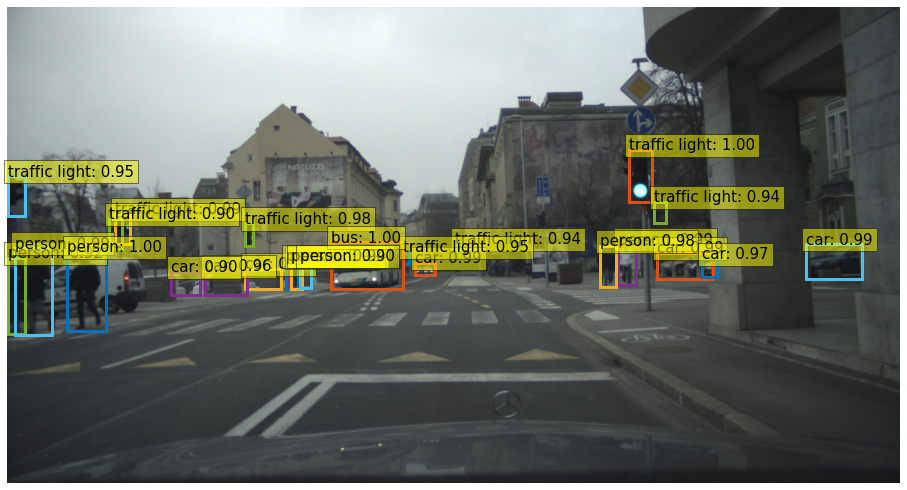

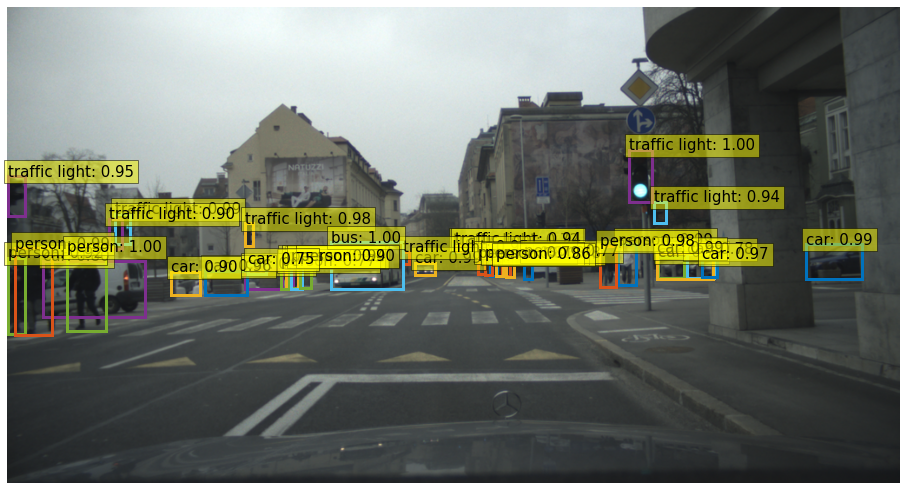

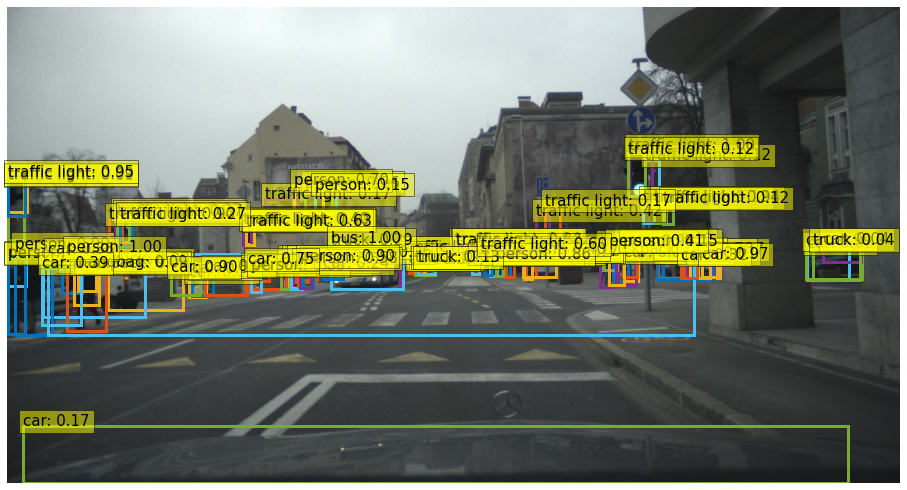

In [9]:
for threshold in [0.9, 0.7, 0.0]:
  
    probas_to_keep, bboxes_scaled = filter_bboxes_from_outputs(outputs,
                                                            threshold=threshold)

    plot_results(im, probas_to_keep, bboxes_scaled)

In [10]:
%cd /content/

!rm -rf detr
!git clone https://github.com/woctezuma/detr.git

%cd detr/

!git checkout finetune

[Errno 2] No such file or directory: '/content/'
/sfs/qumulo/qhome/ybt7qf/ds6050-group1-project
Cloning into 'detr'...
remote: Enumerating objects: 260, done.
remote: Total 260 (delta 0), reused 0 (delta 0), pack-reused 260
Receiving objects: 100% (260/260), 323.68 KiB | 0 bytes/s, done.
Resolving deltas: 100% (124/124), done.
/sfs/qumulo/qhome/ybt7qf/ds6050-group1-project/detr
Branch finetune set up to track remote branch finetune from origin.
Switched to a new branch 'finetune'


In [11]:
# Get pretrained weights
checkpoint = torch.hub.load_state_dict_from_url(
            url='https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth',
            map_location='cpu',
            check_hash=True)

# Remove class weights
del checkpoint["model"]["class_embed.weight"]
del checkpoint["model"]["class_embed.bias"]

# Save
torch.save(checkpoint,
           'detr-r50_no-class-head.pth')

In [12]:
first_class_index = 0

In [13]:
%matplotlib inline
import pycocotools.coco as coco
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import matplotlib.patches as patches
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

In [14]:
dataDir='/scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/'
dataType='train2017'
annFile='{}annotations/custom_train.json'.format(dataDir)

In [15]:
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=1.20s)
creating index...
index created!


In [16]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())

nms=[cat['name'] for cat in cats]
print('Categories: {}'.format(nms))

nms = set([cat['supercategory'] for cat in cats])
print('Super-categories: {}'.format(nms))

Categories: ['buggy-group', 'motorbike', 'person-group-far-away', 'motorbike-group', 'wheelchair-group', 'tricycle-group', 'pedestrian', 'rider+vehicle-group-far-away', 'scooter-group', 'bicycle-group', 'bicycle', 'rider']
Super-categories: {'rider+vehicle-group-far-away', 'wheelchair-group', 'bicycle-group', 'motorbike-group', 'pedestrian', 'bicycle', 'person-group-far-away', 'motorbike', 'buggy-group', 'scooter-group', 'rider', 'tricycle-group'}


In [17]:
# load and display image
catIds = coco.getCatIds(catNms=['pedestrian']);
imgIds = coco.getImgIds(catIds=catIds);

Image n°23665
Image name: /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset//train2017/koeln_00833.png


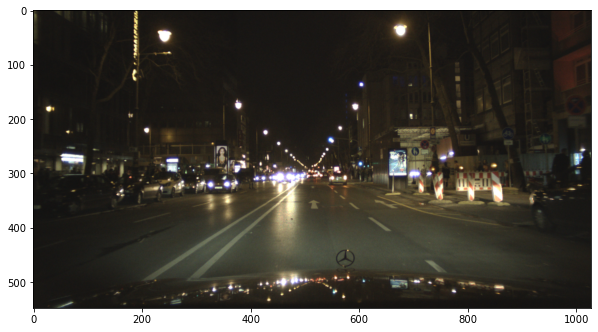

In [18]:
img_id = imgIds[np.random.randint(0,len(imgIds))]
print('Image n°{}'.format(img_id))

img = coco.loadImgs(img_id)[0]

img_name = '%s/%s/%s'%(dataDir, dataType, img['file_name'])
print('Image name: {}'.format(img_name))

I = io.imread(img_name)
plt.figure()
plt.imshow(I)

In [19]:
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds)
anns = coco.loadAnns(annIds)

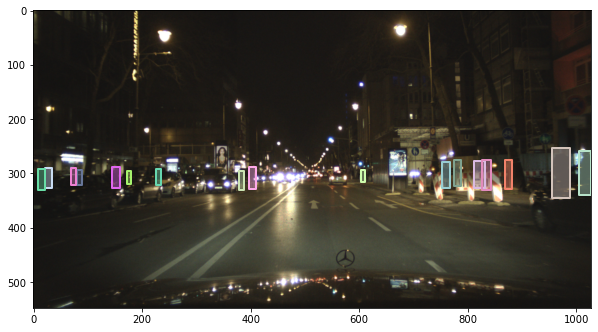

In [20]:
plt.imshow(I)
coco.showAnns(anns, draw_bbox=True)

In [21]:
assert(first_class_index in [0, 1])

num_classes = len(nms)
finetuned_classes = list(nms)

print('First class index: {}'.format(first_class_index))  
print('Parameter num_classes: {}'.format(num_classes))
print('Fine-tuned classes: {}'.format(finetuned_classes))

First class index: 0
Parameter num_classes: 12
Fine-tuned classes: ['rider+vehicle-group-far-away', 'wheelchair-group', 'bicycle-group', 'motorbike-group', 'pedestrian', 'bicycle', 'person-group-far-away', 'motorbike', 'buggy-group', 'scooter-group', 'rider', 'tricycle-group']


In [22]:
import os
os.environ['MASTER_ADDR'] = "127.0.0.1"
os.environ['MASTER_PORT'] = "8888"

In [ ]:
!python main.py \
  --dataset_file "custom" \
  --coco_path "/scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/" \
  --output_dir "outputs" \
  --resume "detr-r50_no-class-head.pth" \
  --num_classes $num_classes \
  --epochs 1 \
  --batch_size 32 \
  --num_workers 15

| distributed init (rank 0): env://
git:
  sha: 3cda3529921efb8870d0b49db7b30aa8477ae359, status: clean, branch: finetune

Namespace(aux_loss=True, backbone='resnet50', batch_size=32, bbox_loss_coef=5, clip_max_norm=0.1, coco_panoptic_path=None, coco_path='/scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/', dataset_file='custom', dec_layers=6, device='cuda', dice_loss_coef=1, dilation=False, dim_feedforward=2048, dist_backend='nccl', dist_url='env://', distributed=True, dropout=0.1, enc_layers=6, eos_coef=0.1, epochs=1, eval=False, frozen_weights=None, giou_loss_coef=2, gpu=0, hidden_dim=256, lr=0.0001, lr_backbone=1e-05, lr_drop=200, mask_loss_coef=1, masks=False, nheads=8, num_classes=12, num_queries=100, num_workers=15, output_dir='outputs', position_embedding='sine', pre_norm=False, rank=0, remove_difficult=False, resume='detr-r50_no-class-head.pth', seed=42, set_cost_bbox=5, set_cost_class=1, set_cost_giou=2, start_epoch=0, weight_decay=0.0001, world_size=1)
/

In [ ]:
from util.plot_utils import plot_logs

from pathlib import Path

log_directory = [Path('/home/ybt7qf/ds6050-group1-project/detr/outputs')]

In [ ]:
fields_of_interest = (
    'loss',
    'mAP',
    )

plot_logs(log_directory,
          fields_of_interest)

In [ ]:
fields_of_interest = (
    'loss_ce',
    'loss_bbox',
    'loss_giou',
    )

plot_logs(log_directory,
          fields_of_interest)

In [ ]:
fields_of_interest = (
    'class_error',
    'cardinality_error_unscaled',
    )

plot_logs(log_directory,
          fields_of_interest)   

In [ ]:
model = torch.hub.load('facebookresearch/detr',
                       'detr_resnet50',
                       pretrained=False,
                       num_classes=num_classes)

checkpoint = torch.load('outputs/checkpoint.pth',
                        map_location='cpu')

model.load_state_dict(checkpoint['model'],
                      strict=False)

model.eval();

In [ ]:
def plot_finetuned_results(pil_img, prob=None, boxes=None):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if prob is not None and boxes is not None:
        for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))
            cl = p.argmax()
            text = f'{finetuned_classes[int(cl)]}: {p[cl]:0.2f}'
            ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [ ]:
def run_worflow(my_image, my_model):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(my_image).unsqueeze(0)

    # propagate through the model
    outputs = my_model(img)

    for threshold in [0.9, 0.7]:

        probas_to_keep, bboxes_scaled = filter_bboxes_from_outputs(outputs,
                                                                  threshold=threshold)

        plot_finetuned_results(my_image,
                               probas_to_keep, 
                               bboxes_scaled)


In [ ]:
from PIL import Image

img_name = '/scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/train2017/roma_02842.png'
im = Image.open(img_name)

run_worflow(im,
            model)